In [76]:
import os
import re
import json
import ast

from pathlib import Path
from copy import deepcopy
from datetime import date, datetime, timedelta


import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from pandarallel import pandarallel

import dgl
import torch

In [28]:
%matplotlib inline
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
df_book = pd.read_csv('datasets/kaggle_books.csv', sep=";", error_bad_lines=False, encoding="latin-1")
df_ratings = pd.read_csv('datasets/kaggle_ratings.csv', sep=";", error_bad_lines=False, encoding="latin-1")
df_user = pd.read_csv('datasets/kaggle_users.csv', sep=";", error_bad_lines=False, encoding="latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/home/chinu/.conda/envs/mlenv/lib/python3.9/site-packages/IPython/core/int

In [38]:
print("Shape of the Book DF is : ", df_book.shape)
df_book.head()

Shape of the Book DF is :  (271360, 5)


,ISBN,publication_year,authors,title,publishers
0,0195153448,2002,mark morford,classical mythology,oxford university press
1,0002005018,2001,richard bruce wright,clara callan,harperflamingo canada
2,0060973129,1991,carlo este,decision normandy,harperperennial
3,0374157065,1999,gina bari kolata,flu story great influenza pandemic 1918 search...,farrar straus giroux
4,0393045218,1999,barber,mummies urumchi,norton amp company


In [7]:
print("Shape of the Ratings DF is : ", df_ratings.shape)
df_ratings.head()

Shape of the Ratings DF is :  (1149780, 3)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [44]:
print("Shape of the User DF is : ", df_user.shape)
df_user.head()

Shape of the User DF is :  (278858, 4)


,User-ID,Location,Age,location
0,1,"nyc, new york, usa",NaN,nyc new york usa
1,2,"stockton, california, usa",18.0,stockton california usa
2,3,"moscow, yukon territory, russia",NaN,moscow yukon territory russia
3,4,"porto, v.n.gaia, portugal",17.0,porto gaia portugal
4,5,"farnborough, hants, united kingdom",NaN,farnborough hants united kingdom


In [10]:
# df_book.columns
df_book.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L',], inplace=True)

In [15]:
df_user.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


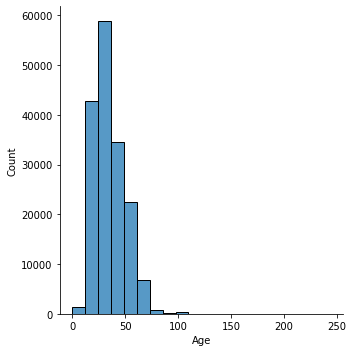

In [18]:
sns.displot(df_user['Age'], bins=20)

<AxesSubplot:xlabel='Age'>

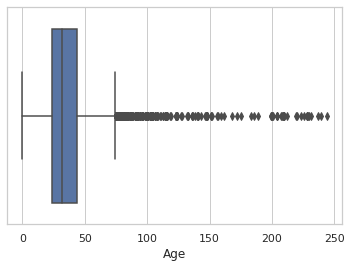

In [19]:
sns.set_theme(style="whitegrid")
sns.boxplot(x=df_user["Age"])

In [25]:
def pre_process(string_value):
    sentence = str(string_value)
    cleantext = re.sub(r"[^a-zA-Z0-9]+", ' ', sentence.lower().strip())
    rem_url=re.sub(r'http\S+', '',cleantext)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_url)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    return " ".join(filtered_words)

In [30]:
df_book["authors"] = df_book['Book-Author'].parallel_apply(pre_process)

In [32]:
df_book["title"] = df_book['Book-Title'].parallel_apply(pre_process)

In [34]:
df_book["publishers"] = df_book['Publisher'].parallel_apply(pre_process)

In [37]:
df_book.rename(columns={"Year-Of-Publication": "publication_year"}, inplace=True)
df_book.drop(columns=['Book-Title', 'Book-Author', 'Publisher',], inplace=True)

In [41]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [58]:
df_user.isnull().sum()

User-ID          0
Location         0
Age         110762
location         0
dtype: int64

In [43]:
df_user['location'] = df_user['Location'].parallel_apply(pre_process)

In [56]:
for index, row in df_user[df_user['Age'] > 119].iterrows():
    print(index, "++", row['Age'])
    df_user['Age'][df_user.index == index] = row['Age'] * 0.1

1578 ++ 231.0
replaced value is :  231.0
8457 ++ 230.0
replaced value is :  230.0
8781 ++ 239.0
replaced value is :  239.0
11325 ++ 148.0
replaced value is :  148.0
12691 ++ 151.0
replaced value is :  151.0
13272 ++ 201.0
replaced value is :  201.0
17902 ++ 123.0
replaced value is :  123.0
20856 ++ 244.0
replaced value is :  244.0
24410 ++ 133.0
replaced value is :  133.0
27717 ++ 123.0
replaced value is :  123.0
28090 ++ 128.0
replaced value is :  128.0
30589 ++ 141.0
replaced value is :  141.0
35860 ++ 148.0
replaced value is :  148.0
37834 ++ 219.0
replaced value is :  219.0
41383 ++ 124.0
replaced value is :  124.0
45688 ++ 175.0
replaced value is :  175.0
46263 ++ 141.0
replaced value is :  141.0
48098 ++ 172.0
replaced value is :  172.0
48280 ++ 124.0
replaced value is :  124.0
50768 ++ 133.0
replaced value is :  133.0
52471 ++ 209.0
replaced value is :  209.0
52648 ++ 212.0
replaced value is :  212.0
58285 ++ 237.0
replaced value is :  237.0
61103 ++ 162.0
replaced value is :  1

<ipython-input-56-f4bd9e6b0bc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['Age'][df_user.index == index] = row['Age'] * 0.1
<ipython-input-56-f4bd9e6b0bc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['Age'][df_user.index == index] = row['Age'] * 0.1
<ipython-input-56-f4bd9e6b0bc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['Age'][df_user.index == index] = row['Age'] * 0.1
<ipython-input-56-f4bd

replaced value is :  183.0
184860 ++ 204.0
replaced value is :  204.0
184948 ++ 147.0
replaced value is :  147.0
190646 ++ 204.0
replaced value is :  204.0
192412 ++ 228.0
replaced value is :  228.0
196035 ++ 148.0
replaced value is :  148.0
210012 ++ 204.0
replaced value is :  204.0
211520 ++ 223.0
replaced value is :  223.0
216665 ++ 208.0
replaced value is :  208.0
217550 ++ 124.0
replaced value is :  124.0
218682 ++ 157.0
replaced value is :  157.0
221391 ++ 123.0
replaced value is :  123.0
225525 ++ 124.0
replaced value is :  124.0
225959 ++ 146.0
replaced value is :  146.0
226615 ++ 204.0
replaced value is :  204.0
242213 ++ 228.0
replaced value is :  228.0
245084 ++ 123.0
replaced value is :  123.0
245230 ++ 220.0
replaced value is :  220.0
257113 ++ 210.0
replaced value is :  210.0
257429 ++ 200.0
replaced value is :  200.0
261553 ++ 143.0
replaced value is :  143.0
264933 ++ 140.0
replaced value is :  140.0
275582 ++ 189.0
replaced value is :  189.0
276047 ++ 127.0
replaced va

<ipython-input-56-f4bd9e6b0bc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['Age'][df_user.index == index] = row['Age'] * 0.1
<ipython-input-56-f4bd9e6b0bc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['Age'][df_user.index == index] = row['Age'] * 0.1
<ipython-input-56-f4bd9e6b0bc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['Age'][df_user.index == index] = row['Age'] * 0.1
<ipython-input-56-f4bd

In [64]:
# df_user['Age'].mode()
df_user['Age'].fillna(df_user['Age'].mode()[0], inplace=True)

In [66]:
df_user.isnull().sum()

User-ID     0
Location    0
Age         0
location    0
dtype: int64

In [68]:
df_rat_rand = df_ratings.sample(frac=1, random_state=7)
training_test_index = round(len(df_rat_rand) * 0.7)
training_test_index

804846

In [69]:
training_set = df_rat_rand[:training_test_index].reset_index(drop=True)
test_set = df_rat_rand[training_test_index:].reset_index(drop=True)

In [71]:
test_set

,User-ID,ISBN,Book-Rating
0,201353,0590483463,6
1,246617,0330480413,0
2,55548,0060919655,0
3,110029,0006482066,0
4,113537,3518396315,10
...,...,...,...
344929,16795,0451144325,0
344930,203380,0600588564,7
344931,129074,0449206637,0
344932,138097,0679433015,0


In [72]:
#Removed enties of non existing user id and isbn from test not available in train

test_set_new = test_set[test_set['User-ID'].isin(training_set['User-ID']) &
                      test_set['ISBN'].isin(training_set['ISBN'])]

In [74]:
test_set_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255238 entries, 0 to 344933
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      255238 non-null  int64 
 1   ISBN         255238 non-null  object
 2   Book-Rating  255238 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.8+ MB


In [75]:
train_data = training_set.astype({'User-ID': 'category', 'ISBN': 'category'})
test_data = test_set_new.astype({'User-ID': 'category', 'ISBN': 'category'})

In [77]:
train_user_ids = torch.LongTensor(train_data['User-ID'].cat.codes.values)
train_item_ids = torch.LongTensor(train_data['ISBN'].cat.codes.values)
train_ratings = torch.LongTensor(train_data['Book-Rating'].values)
test_user_ids = torch.LongTensor(test_data['User-ID'].cat.codes.values)
test_item_ids = torch.LongTensor(test_data['ISBN'].cat.codes.values)
test_ratings = torch.LongTensor(test_data['Book-Rating'].values)

<ipython-input-77-d3058a5be1c0>:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755883846/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  train_user_ids = torch.LongTensor(train_data['User-ID'].cat.codes.values)


In [80]:
train_ratings

tensor([ 9, 10, 10,  ...,  0,  0,  0])

In [81]:
graph = dgl.heterograph({
    # Heterogeneous graphs are organized as a dictionary of edges connecting two types of nodes.
    # We specify the edges of a type simply with a pair of user ID array and item ID array.
    ('user', 'read', 'item'): (train_user_ids, train_item_ids),
    # Since DGL graphs are directional, we need an inverse relation from items to users as well.
    ('item', 'read-by', 'user'): (train_item_ids, train_user_ids)
})

In [89]:
graph

Graph(num_nodes={'item': 274875, 'user': 86105},
      num_edges={('item', 'read-by', 'user'): 804846, ('user', 'read', 'item'): 804846},
      metagraph=[('item', 'user', 'read-by'), ('user', 'item', 'read')])

In [84]:
!pip install --upgrade networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 939.8 kB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.4
    Uninstalling networkx-2.8.4:
      Successfully uninstalled networkx-2.8.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rasa 3.1.0 requires attrs<21.3,>=19.3, but you have attrs 21.4.0 which is incompatible.
rasa 3.1.0 requires cloudpickle<1.7,>=1.2, but you have cloudpickle 2.0.0 which is incompatible.
rasa 3.1.0 requires dask==2021.11.2, but you have dask 2022.2.1 which is incompatible.
rasa 3.1.0 requires networkx<2.7,>=2.4, but you have networkx 2.8.6 which is incompatible.
rasa 3.1.0 requires numpy<1.20.0,>=1.19.2, but you have numpy 1.21.5 which is incompatible.
rasa 3.1.0 requires packaging<21.0,>=20.0, but you have packaging 21.3 which is incompatible.
rasa 3.1.0 requi

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/chinu/.conda/envs/mlenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-88-b8e73fa24b87>", line 5, in <cell line: 5>
    nx.draw(graph)
  File "/home/chinu/.conda/envs/mlenv/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py", line 120, in draw
  File "/home/chinu/.conda/envs/mlenv/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py", line 331, in draw_networkx
    Parameters
  File "<class 'networkx.utils.decorators.argmap'> compilation 4", line 4, in argmap_spring_layout_1
    import inspect
  File "/home/chinu/.conda/envs/mlenv/lib/python3.9/site-packages/networkx/drawing/layout.py", line 442, in spring_layout
    G, center = _process_params(G, center, dim)
  File "/home/chinu/.conda/envs/mlenv/lib/python3.9/site-packages/networkx/drawing/layout.py", line 44, in _process_params
    empty_graph.add_nodes_from(G)

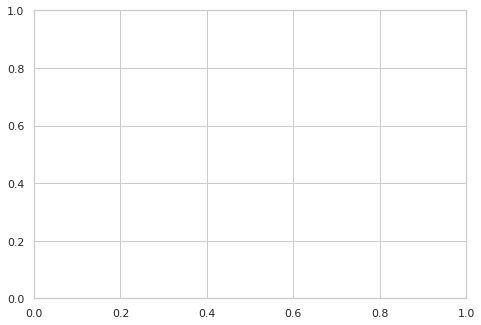

In [88]:
import networkx as nx

# The metagraph is shown in the figure below.  Note the bidirectional arrows.
# nx.draw_networkx_edges(graph.metagraph, )
nx.draw(graph)

In [91]:
df_user['User-ID']

0              1
1              2
2              3
3              4
4              5
           ...  
278853    278854
278854    278855
278855    278856
278856    278857
278857    278858
Name: User-ID, Length: 278858, dtype: int64

In [92]:
df_user['User-ID'] = df_user['User-ID'].astype('category')
df_user['User-ID'] = df_user['User-ID'].cat.set_categories(train_data['User-ID'].cat.categories)

# df_user = df_user.dropna(subset=[0])
# df_user['User-ID'] = df_user['User-ID'].cat.codes
# df_user = df_user.sort_values('User-ID')

df_book['ISBN'] = df_book['ISBN'].astype('category')
df_book['ISBN'] = df_book['ISBN'].cat.set_categories(train_data['ISBN'].cat.categories)

# df_book = df_book.dropna(subset=[0])
# df_book['ISBN'] = df_book['ISBN'].cat.codes
# df_book = df_book.sort_values('ISBN')


In [ ]:
# Convert the age, gender, and occupation column to categorical
df_user['location'] = df_user['location'].astype('category')
df_user.drop(columns='Location', inplace=True)

user_age = df_user['Age'].values // 10
num_user_age_bins = user_age.max() + 1     # count the number of user age bins
